## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install pytorch-tabnet

In [ ]:
# !pip install scikeras

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, accuracy_score, classification_report, r2_score as r2
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
import torch
import keras
from keras.constraints import max_norm as MaxNorm
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from sklearn.pipeline import make_pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import time

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

## Define Variables

In [ ]:
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Number of Tnx Error',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'avg gas fee', 'total transactions (including tnx to create contract)',
       'total ether received', 'total ether balance']

In [ ]:
# columns = ["Time Diff between first and last (Mins)", "avg val received", "min value received",
#            "total transactions (including tnx to create contract)", "max value received ", "Received Tnx",
#            "Sent tnx", "Unique Received From Addresses", "Unique Sent To Addresses", "Avg min between sent tnx"]

In [ ]:
col = ['Address', 'FLAG']

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Data/address_data_combined.csv"

In [ ]:
selected_columns = columns + col

## Load Data

In [ ]:
# Danh sách các cột bạn muốn đọc
 # columns và col là danh sách các cột bạn muốn đọc

# Đọc chỉ các cột được chỉ định từ tệp CSV
df = pd.read_csv(data_path, usecols=selected_columns)

In [ ]:
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

## Slpit Data

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
np.isnan(X_train_full).any()

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(13850, 14)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Number of Tnx Error,Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,avg gas fee,total transactions (including tnx to create contract),total ether received,total ether balance
10717,871.89,227.56,3981.02,0,5,0.505000,0.995159,0.687628,0.227580,1.374837,0.000420,9,4.125770,0.001260
16860,8.84,2842.91,564638.30,0,2,0.033780,0.137001,0.109738,0.067090,0.109202,0.000892,395,21.728162,0.215323
13246,0.00,0.00,0.00,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
17320,23.70,590.11,509889.90,0,1,0.100181,4.590070,0.234468,0.099761,0.236328,0.000420,1654,194.843251,0.345681
19171,8813.61,203.80,47940.22,0,18,0.005000,19.988068,3.532251,9.110564,13.422113,0.000441,24,67.112769,0.002205


In [ ]:
scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
# only use training data to fit, to avoid data leakage
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
np.isnan(X_train_full).any()

## Config Model

In [ ]:
#Optimal Parameters for each model from hyperparameter tuning
tabnet_params = {'gamma': 1.0,
                 'lambda_sparse': 0,
                 'momentum': 0.4,
                 'n_steps': 8,
                 'optimizer_params': {'lr': 0.025},
                 'verbose': 0}

xgb_params = {'learning_rate': 0.05,
              'max_depth': 8,
              'n_estimators': 1000}


mlp_params = {'input_dim': X_train_full.shape[1],
              'H': 60,
              'activation': 'relu',
              'dropout_probability': 0.2,
              'num_epochs': 75,
              'num_layers': 10}

svm_params = {'C': 1000,
              'gamma': 1}

rf_params = {'max_depth': 20,
               'min_samples_leaf': 5,
               'n_jobs': -1}

lightgbm_params = {"bagging_fraction": 0.95,
                   "bagging_freq": 1,
                   "feature_fraction": 0.95,
                   "learning_rate": 0.2,
                   "max_bin": 300,
                   "max_depth": 6,
                   "min_gain_to_split": 0,
                   "num_leaves": 20}

## Functions

In [ ]:
def compile_mlp(input_dim, H, num_epochs, num_layers, activation, dropout_probability):
    # Creating Sequential MLP
    model_n = Sequential()
    model_n.add(layers.Dense(H, input_shape=(input_dim, ), activation= activation))

    for _ in range(num_layers - 1):
        model_n.add(layers.Dense(H, activation= activation, kernel_constraint=MaxNorm(3)))
        model_n.add(layers.Dropout(dropout_probability))

    model_n.add(layers.Dense(1, activation='sigmoid'))
    # configure the model
    model_n.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True)])
    return model_n

In [ ]:
def get_models():
    models = dict()
    mlp = KerasClassifier(model = compile_mlp, **mlp_params)
    tabnet = TabNetClassifier(**tabnet_params)
    models['tabnet'] = tabnet
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = mlp
    models['lightGBM'] = lgb.LGBMClassifier(**lightgbm_params)
    models['randomforest'] = RandomForestClassifier(**rf_params)
    return models


In [ ]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)#, error_score='raise')
    return scores

In [ ]:
#Pipeline to get all models
def get_models2():
    models = dict()
    models['tabnet'] = TabNetClassifier(**tabnet_params)
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = KerasClassifier(model = compile_mlp, **mlp_params)
    models['lightGBM'] = lgb.LGBMClassifier(**lightgbm_params)
    models['RF'] = RandomForestClassifier(**rf_params)
    return models

## Train and Test

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


>tabnet 0.937 (0.004)
>svm 0.947 (0.003)
>xgboost 0.964 (0.002)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>mlp 0.828 (0.016)
>lightGBM 0.962 (0.003)
>randomforest 0.955 (0.004)


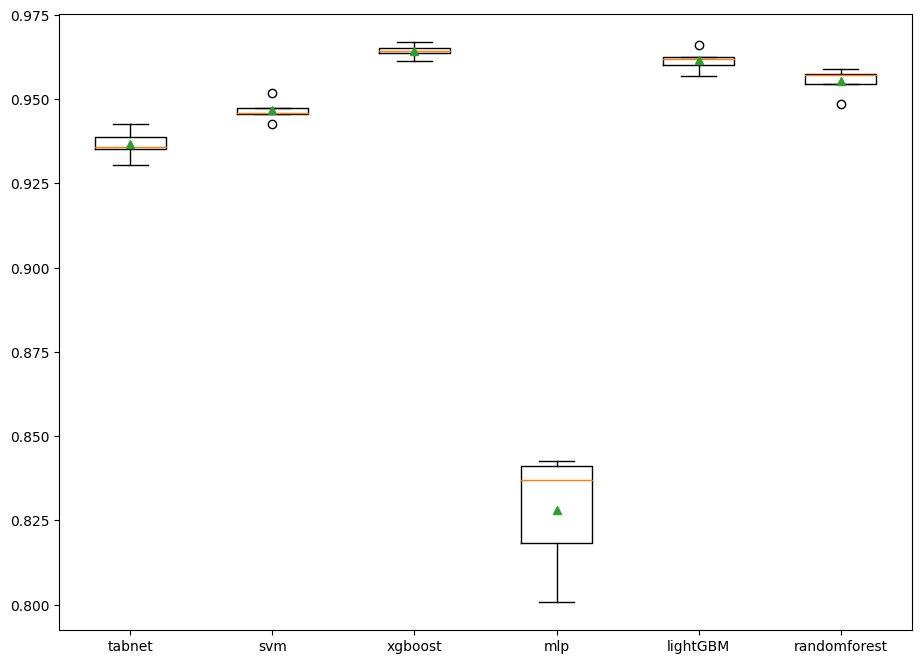

In [ ]:
# define dataset
X, y = X_train_full, y_train_full
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Result

In [ ]:
#Getting predictions from all models to evaluate performance on test set
predictions, names2, training_times, prediction_times = list(), list(), list(), list()
for name, model in get_models2().items():
    current_time = time.time()
    model.fit(X, y)
    training_times.append(time.time() - current_time)

    current_time = time.time()
    predictions.append(model.predict(X_test))
    prediction_times.append(time.time() - current_time)

    names2.append(name)

433/433 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - auc: 0.6636 - loss: 0.6269
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsa

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score

results_df = pd.DataFrame()
results_df['Model'] = names2
results_df['Training Time'] = training_times
results_df['Prediction Time'] = prediction_times
results_df['Optimal Parameters'] = [tabnet_params,
                                    svm_params,
                                    xgb_params,
                                    mlp_params,
                                    lightgbm_params,
                                    rf_params]

metrics_dict = {'Accuracy': accuracy_score,
                'Precision': precision_score,
                'Recall': recall_score,
                'F1': f1_score,
                'ROC-AUC': roc_auc_score}

for metric, func in metrics_dict.items():
    storage = []
    for prediction in predictions:
        storage.append(func(y_test, prediction))
    results_df[metric] = storage

results_df.sort_values(['Accuracy', 'ROC-AUC'], ascending = [False, False])

,Model,Training Time,Prediction Time,Optimal Parameters,Accuracy,Precision,Recall,F1,ROC-AUC
4,lightGBM,0.259473,0.035142,"{'bagging_fraction': 0.95, 'bagging_freq': 1, ...",0.958733,0.963017,0.965547,0.964281,0.957495
2,xgboost,2.905032,0.205837,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.954522,0.960584,0.960584,0.960584,0.953421
5,RF,1.851262,0.053498,"{'max_depth': 20, 'min_samples_leaf': 5, 'n_jo...",0.948290,0.954519,0.955912,0.955215,0.946905
0,tabnet,117.281656,0.235708,"{'gamma': 1.0, 'lambda_sparse': 0, 'momentum':...",0.939869,0.954384,0.940730,0.947508,0.939712
1,svm,12.033877,0.690457,"{'C': 1000, 'gamma': 1}",0.937511,0.942352,0.949781,0.946052,0.935281
3,mlp,44.716187,1.521063,"{'input_dim': 14, 'H': 60, 'activation': 'relu...",0.832744,0.847230,0.866277,0.856648,0.826650


from matplotlib import pyplot as plt
_df_0['Training Time'].plot(kind='hist', bins=20, title='Training Time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Prediction Time'].plot(kind='hist', bins=20, title='Prediction Time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Training Time', y='Prediction Time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Prediction Time', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training Time']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Training Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training Time')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training Time']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Training Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training Time')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training Time']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Training Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training Time')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training Time']
  ys = series['F1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Training Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training Time')
_ = plt.ylabel('F1')

from matplotlib import pyplot as plt
_df_13['Training Time'].plot(kind='line', figsize=(8, 4), title='Training Time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Prediction Time'].plot(kind='line', figsize=(8, 4), title='Prediction Time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Training Time', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Prediction Time', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/result.csv", index=False)